In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from pyDOE import lhs

import os
import time

plt.rcParams.update({'font.size':18})

In [2]:
mlp_layers = [2, 128, 128, 128, 128, 128, 128, 1]
domain = (-1, 1, -1, 1)
xmin, xmax, ymin, ymax = domain
mlp_layers = [2, 128, 128, 128, 128, 128, 128, 1]
Nsd = 10000
n_b = 128
class MLP(nn.Module):
    def __init__(self, mlp_layers):
        super(MLP, self).__init__()
        
        self.model = nn.Sequential()
        for i in range(len(mlp_layers)-2):
            layer = nn.Sequential()
            layer.add_module(f'fc{i}', nn.Linear(mlp_layers[i], mlp_layers[i+1], bias=True))
            layer.add_module(f'act{i}', nn.Tanh())
            self.model.add_module(f'layer{i}', layer)

        last_layer = nn.Sequential()
        last_layer.add_module(f'fc{len(mlp_layers)-2}', nn.Linear(mlp_layers[-2], mlp_layers[-1], bias=False))
        self.model.add_module(f'layer{len(mlp_layers)-2}', last_layer)
        
        for param in self.parameters():
            if len(param.shape) > 1:
                nn.init.kaiming_normal_(param)
    
    def forward(self, X):
        return self.model(X)
    
    
backbone = MLP(mlp_layers)
backbone.model

Sequential(
  (layer0): Sequential(
    (fc0): Linear(in_features=2, out_features=128, bias=True)
    (act0): Tanh()
  )
  (layer1): Sequential(
    (fc1): Linear(in_features=128, out_features=128, bias=True)
    (act1): Tanh()
  )
  (layer2): Sequential(
    (fc2): Linear(in_features=128, out_features=128, bias=True)
    (act2): Tanh()
  )
  (layer3): Sequential(
    (fc3): Linear(in_features=128, out_features=128, bias=True)
    (act3): Tanh()
  )
  (layer4): Sequential(
    (fc4): Linear(in_features=128, out_features=128, bias=True)
    (act4): Tanh()
  )
  (layer5): Sequential(
    (fc5): Linear(in_features=128, out_features=128, bias=True)
    (act5): Tanh()
  )
  (layer6): Sequential(
    (fc6): Linear(in_features=128, out_features=1, bias=False)
  )
)

In [3]:
class DatasetAC:
    def __init__(self, domain):
        self.domain = domain
    
    def train_data(self, verbose=None):
        xmin, xmax, ymin, ymax = self.domain
        # 内部点采样
        
#         lb1 = np.array([-1., -1.])
#         ub1 = np.array([0., 0.])
#         lb2 = np.array([-1., 0.])
#         ub2 = np.array([0., 1.])
#         lb3 = np.array([0.0, -1.])
#         ub3 = np.array([1., 0.])

#         xy_res1 = (ub1-lb1)*lhs(2, int(Nsd/3))+lb1
#         xy_res2 = (ub2-lb2)*lhs(2, int(Nsd/3))+lb2
#         xy_res3 = (ub3-lb3)*lhs(2, int(Nsd/3))+lb3
        
#         X_res = np.concatenate([xy_res1, xy_res2, xy_res3], 0)

        lb = np.array([-1.0, -1.0])
        ub = np.array([1.0, 1.0])
        xy = (ub-lb)*lhs(2, Nsd)+lb
        xy = xy[~((xy[:,0]>=0) * (xy[:,1]>=0))]
        
        # 边界点采样
        
#         # 对于x
#         lb_bcs_1 = np.array([-1., -1.])
#         ub_bcs_1 = np.array([1., -1.])
#         lb_bcs_2 = np.array([-1., 1.])
#         ub_bcs_2 = np.array([0.0, 1.])
#         lb_bcs_3 = np.array([0.0, 0.0])
#         ub_bcs_3 = np.array([1., 0.0])
#         xy_bcs_1 = (ub_bcs_1-lb_bcs_1)*lhs(2, n_bcs)+lb_bcs_1
#         xy_bcs_2 = (ub_bcs_2-lb_bcs_2)*lhs(2, n_bcs)+lb_bcs_2
#         xy_bcs_3 = (ub_bcs_3-lb_bcs_3)*lhs(2, n_bcs)+lb_bcs_3
#         xy_bcs_x = np.concatenate([xy_bcs_1,xy_bcs_2,xy_bcs_3],0)
#         # 对于y
#         lb_bcs_4 = np.array([-1., -1.])
#         ub_bcs_4 = np.array([-1., 1.])
#         lb_bcs_5 = np.array([0.0, 0.0])
#         ub_bcs_5 = np.array([0.0, 1.])
#         lb_bcs_6 = np.array([1., -1.])
#         ub_bcs_6 = np.array([1., 0.0])
#         xy_bcs_4 = (ub_bcs_4-lb_bcs_4)*lhs(2, n_bcs)+lb_bcs_4
#         xy_bcs_5 = (ub_bcs_5-lb_bcs_5)*lhs(2, n_bcs)+lb_bcs_5
#         xy_bcs_6 = (ub_bcs_6-lb_bcs_6)*lhs(2, n_bcs)+lb_bcs_6
#         xy_bcs_y = np.concatenate([xy_bcs_4,xy_bcs_5,xy_bcs_6],0)
#         X_bcs = np.concatenate([xy_bcs_x,xy_bcs_y],0)


        bound_1 = lhs(1, n_b)-1 # -1 -> 0
        bound_1 = bound_1.reshape(-1,1)
        
        bound_2 = lhs(1, n_b) # 0 -> 1
        bound_2 = bound_2.reshape(-1,1)
        
        xy_b_1 = np.hstack((bound_1, bound_1*0-1))
        xy_b_2 = np.hstack((bound_2, bound_2*0-1))
        xy_b_3 = np.hstack((bound_1*0-1, bound_1))
        xy_b_4 = np.hstack((bound_1*0-1, bound_2))
        xy_b_5 = np.hstack((bound_1, bound_1*0+1))
        xy_b_6 = np.hstack((bound_2, bound_1*0))
        xy_b_7 = np.hstack((bound_1*0+1, bound_1))
        xy_b_8 = np.hstack((bound_1*0, bound_2))        
        xy_b = np.vstack([xy_b_1, xy_b_2, xy_b_3, xy_b_4, xy_b_5, xy_b_6, xy_b_7, xy_b_8])
        
        xy = torch.from_numpy(xy).float()
        xy_b = torch.from_numpy(xy_b).float()
        return xy, xy_b
    
    def sample_xy(self, x, y):
        xx, yy = np.meshgrid(x, y)
        X = np.concatenate([xx.reshape((-1, 1)), yy.reshape((-1, 1))], axis=1)
        return X
    

dataset = DatasetAC(domain)
X_res, X_bcs = dataset.train_data()
print(X_res.shape, X_bcs.shape)

torch.Size([7535, 2]) torch.Size([1024, 2])


In [4]:
def points_weight_fn1(X):
    if torch.is_tensor(X):
        d = torch.sqrt((X[:, [0]]-1)**2 + (X[:, [1]]-1)**2)
    else:
        d = np.sqrt((X[:, [0]]-1)**2 + (X[:, [1]]-1)**2)
    return -2 * d + 6.2

def points_weight_fn2(X):
    if torch.is_tensor(X):
        d = torch.sqrt((X[:, [0]]-1)**2 + (X[:, [1]]-1)**2)
        return 8 * torch.exp(-0.78*d)
    else:
        d = np.sqrt((X[:, [0]]-1)**2 + (X[:, [1]]-1)**2)
        return 8 * np.exp(-0.78*d)

def points_weight_fn3(X):
    if torch.is_tensor(X):
        d = torch.sqrt((X[:, [0]]-1)**2 + (X[:, [1]]-1)**2)
    else:
        d = np.sqrt((X[:, [0]]-1)**2 + (X[:, [1]]-1)**2)
    return -0.3*d**2 + 3.8

In [5]:
fixed_w1 = points_weight_fn1(X_res).cpu()
fixed_w2 = points_weight_fn2(X_res).cpu()
fixed_w3 = points_weight_fn3(X_res).cpu()
X_res = X_res.cpu()

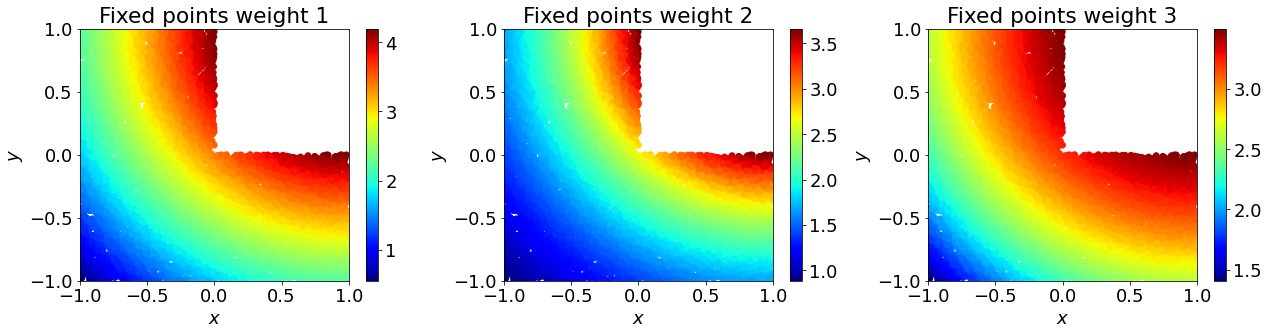

In [6]:
fig = plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
plt.scatter(X_res[:, 0], X_res[:, 1], c=fixed_w1[:, 0], cmap='jet')
plt.colorbar()
plt.xlim([xmin, xmax])
plt.ylim([ymin, ymax])
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('Fixed points weight 1')
plt.tight_layout()

plt.subplot(1, 3, 2)
plt.scatter(X_res[:, 0], X_res[:, 1], c=fixed_w2[:, 0], cmap='jet')
plt.colorbar()
plt.xlim([xmin, xmax])
plt.ylim([ymin, ymax])
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('Fixed points weight 2')
plt.tight_layout()

plt.subplot(1, 3, 3)
plt.scatter(X_res[:, 0], X_res[:, 1], c=fixed_w3[:, 0], cmap='jet')
plt.colorbar()
plt.xlim([xmin, xmax])
plt.ylim([ymin, ymax])
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('Fixed points weight 3')
plt.tight_layout()

plt.savefig('weight_possion_Lshape.png', dpi=400)
plt.show()

In [7]:
def grad(outputs, inputs):
    return torch.autograd.grad(outputs, inputs,
                               grad_outputs=torch.ones_like(outputs),
                               create_graph=True, 
                               retain_graph=True)

In [8]:
class PINNAC(nn.Module):
    def __init__(self, backbone, mu=None, sigma=None, points_weight_fn=None):
        super(PINNAC, self).__init__()
        self.backbone = backbone
        self.d = 0.0001
        if mu is not None and sigma is not None:
            self.is_inputs_normalization = True
            self.mu = mu
            self.sigma = sigma
            print(f'forward with normalization, mu={self.mu.tolist()}, sigma={self.sigma.tolist()}')
        else:
            self.is_inputs_normalization = False
            
        if points_weight_fn is not None:
            self.is_pw_fn = True
            self.pw_fn = points_weight_fn
        else:
            self.is_pw_fn = False
    
    def forward(self, X_res, X_bcs):
        if self.is_pw_fn:
            pw_res = self.pw_fn(X_res)
            pw_res.requires_grad_(False)
            loss_res = torch.mean(self.net_f(pw_res * X_res)**2)
        else:
            loss_res = torch.mean(self.net_f(X_res)**2)
        loss_bcs = torch.mean(self.net_u(X_bcs)**2)
        return loss_res, loss_bcs
    
    def net_u(self, X):
        if self.is_inputs_normalization == True:
            X = (X - self.mu) / self.sigma
        return self.backbone(X)
    
    def net_f(self, X_res):
        X_res.requires_grad_(True)
        u = self.net_u(X_res)

        grad_u = grad(u, X_res)[0]
        u_x = grad_u[:,[0]]
        u_y = grad_u[:,[1]]
        u_xx = grad(u_x, X_res)[0][:,[0]]
        u_yy = grad(u_y, X_res)[0][:,[1]]

        return 1 + u_xx + u_yy
    

pinn = PINNAC(backbone)

In [9]:
model_path = r'./model'
model_state = torch.load(os.path.join(model_path, 'backbone_adam.pth'),map_location=torch.device('cpu'))
pinn.backbone.load_state_dict(model_state['state_dict'])

<All keys matched successfully>

In [11]:
data = scipy.io.loadmat('Lpoission_more.mat')

x = data['x']
y = data['y']
u_star = data['z']

X = np.concatenate([x.reshape((-1, 1)), y.reshape((-1, 1))], axis=1)
u_star = u_star.reshape((1, -1))
X.shape
u_star.shape

(1, 109610)

In [12]:
pinn.eval()
# X = np.hstack((xx.reshape(-1,1), yy.reshape(-1,1)))
X = torch.from_numpy(X).double()

mu = X.mean(dim=0)
sigma = X.std(dim=0)  # 求样本标准差

backbone = MLP(mlp_layers)
# 使用第一种权重生成方法
pinn = PINNAC(backbone, mu, sigma)

pinn.mu = pinn.mu.cpu().double()
pinn.sigma = pinn.sigma.cpu().double()
pinn = pinn.cpu().double()
u_pred = pinn.net_u(X).detach().numpy()
u_pred = u_pred.reshape(x.shape)

error = np.linalg.norm(u_pred - u_star) / np.linalg.norm(u_star)
print('Relative l2 error: {:.3e}'.format(error))
u_pred.shape

forward with normalization, mu=[-0.14409959707998815, -0.14409959707998815], sigma=[0.5488775273375922, 0.548877527337595]
Relative l2 error: 6.422e+00


(1, 109610)

NameError: name 'loss_r_log_adam' is not defined

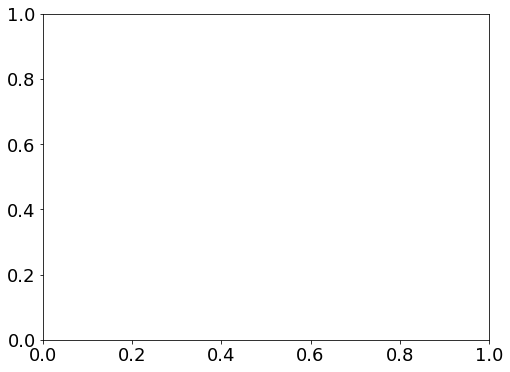

In [13]:
plt.figure(figsize=(8, 6))
plt.subplot(111)
plt.plot(loss_r_log_adam+loss_r_log_lbfgs, label='$loss_r$')
plt.plot(loss_b_log_adam+loss_b_log_lbfgs, label='$loss_b$')
plt.xlabel('epochs')
plt.yscale('loss')
plt.legend()
plt.grid()
plt.savefig('loss_log.png', dpi=100)
plt.show()
plt.savefig('loss_possion_Lshape.png', dpi=400)